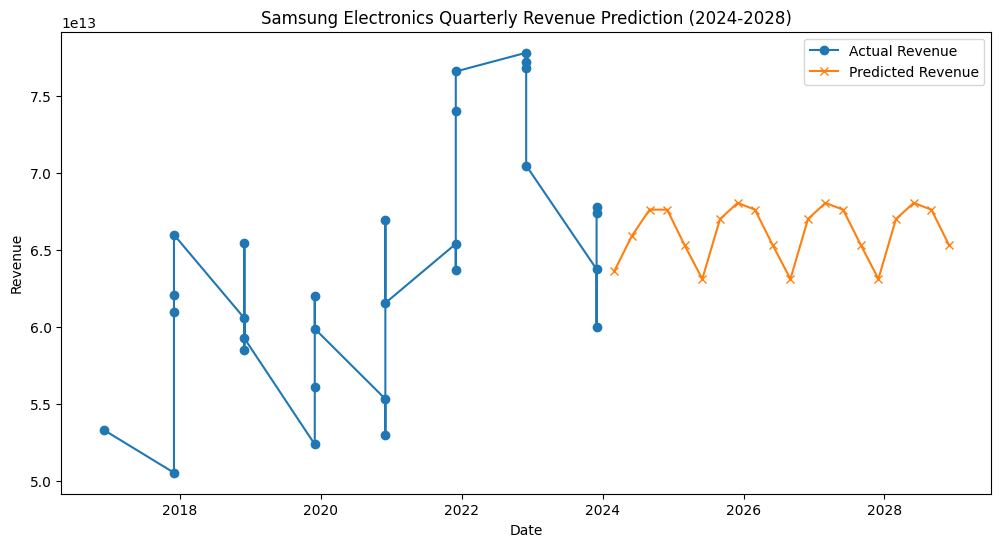

           ds          yhat
0  2024-03-01  6.359608e+13
1  2024-06-01  6.590951e+13
2  2024-09-01  6.761014e+13
3  2024-12-01  6.760419e+13
4  2025-03-01  6.530659e+13
5  2025-06-01  6.310931e+13
6  2025-09-01  6.699952e+13
7  2025-12-01  6.804240e+13
8  2026-03-01  6.760446e+13
9  2026-06-01  6.530670e+13
10 2026-09-01  6.310931e+13
11 2026-12-01  6.699952e+13
12 2027-03-01  6.804240e+13
13 2027-06-01  6.760446e+13
14 2027-09-01  6.530670e+13
15 2027-12-01  6.310931e+13
16 2028-03-01  6.699952e+13
17 2028-06-01  6.804240e+13
18 2028-09-01  6.760446e+13
19 2028-12-01  6.530670e+13


In [32]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])

# 특징 공학: 분기, 연도 및 과거 매출 데이터를 포함
df['quarter'] = df['ds'].dt.quarter
df['year'] = df['ds'].dt.year
df['prev_y'] = df['y'].shift(1)
df['prev_y2'] = df['y'].shift(2)
df['prev_y3'] = df['y'].shift(3)
df = df.dropna()  # NaN 값 제거

# 데이터 준비
X = df[['year', 'quarter', 'prev_y', 'prev_y2', 'prev_y3']]
y = df['y']

# XGBoost 모델 학습
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X, y)

# 2024년부터 2028년까지의 분기 데이터 생성
future_years = np.arange(2024, 2029)
future_quarters = [1, 2, 3, 4]
future_data = [(year, quarter) for year in future_years for quarter in future_quarters]
future_df = pd.DataFrame(future_data, columns=['year', 'quarter'])

# 초기 과거 매출 데이터 생성
last_values = df[['year', 'quarter', 'y']].tail(3).reset_index(drop=True)
future_df['prev_y'] = np.nan
future_df['prev_y2'] = np.nan
future_df['prev_y3'] = np.nan

for i in range(len(future_df)):
    if i < 3:
        future_df.loc[i, 'prev_y'] = last_values.loc[i, 'y']
        future_df.loc[i, 'prev_y2'] = last_values.loc[i - 1, 'y'] if i - 1 >= 0 else last_values.loc[2, 'y']
        future_df.loc[i, 'prev_y3'] = last_values.loc[i - 2, 'y'] if i - 2 >= 0 else last_values.loc[1, 'y']
    else:
        future_df.loc[i, 'prev_y'] = future_df.loc[i - 1, 'yhat']
        future_df.loc[i, 'prev_y2'] = future_df.loc[i - 2, 'yhat']
        future_df.loc[i, 'prev_y3'] = future_df.loc[i - 3, 'yhat']

    # 미래 데이터 예측
    future_df.loc[i, 'yhat'] = model.predict(future_df.loc[i:i, ['year', 'quarter', 'prev_y', 'prev_y2', 'prev_y3']])[0]

# 예측 결과 데이터프레임 생성
future_df['ds'] = future_df.apply(lambda row: f"{int(row['year'])}-{'03' if row['quarter'] == 1 else '06' if row['quarter'] == 2 else '09' if row['quarter'] == 3 else '12'}-01", axis=1)
future_df['ds'] = pd.to_datetime(future_df['ds'])

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])



Epoch 1/100
28/28 [==============================] - 11s 7ms/step - loss: 0.1242
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0452
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0447
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0395
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0448
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0538
Epoch 7/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0532
Epoch 8/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0504
Epoch 9/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0400
Epoch 10/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0553
Epoch 11/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0463
Epoch 12/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0488
Epoch 13/100
28/28 [================

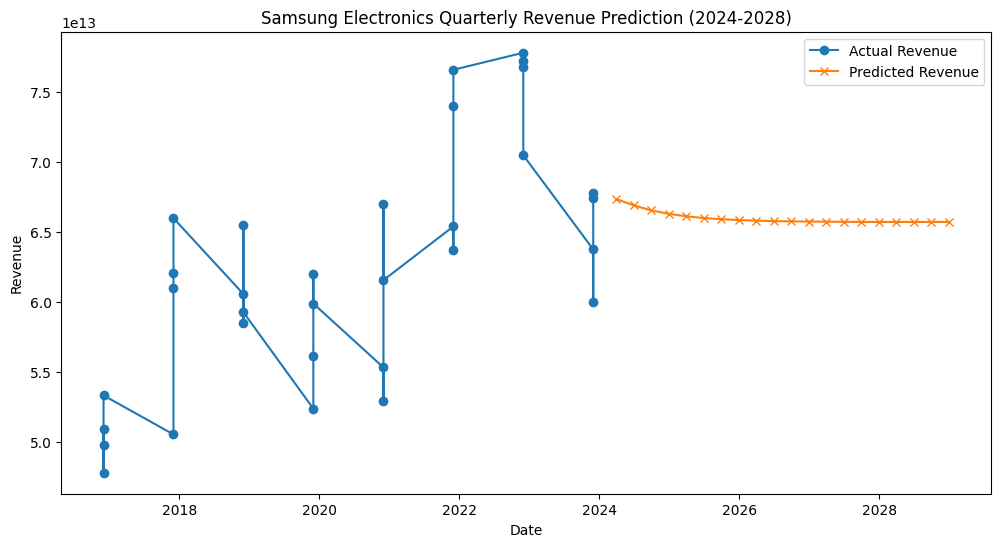

           ds          yhat
0  2024-03-31  6.733771e+13
1  2024-06-30  6.688720e+13
2  2024-09-30  6.653060e+13
3  2024-12-31  6.628348e+13
4  2025-03-31  6.610937e+13
5  2025-06-30  6.598669e+13
6  2025-09-30  6.590334e+13
7  2025-12-31  6.584254e+13
8  2026-03-31  6.580061e+13
9  2026-06-30  6.576971e+13
10 2026-09-30  6.574766e+13
11 2026-12-31  6.573872e+13
12 2027-03-31  6.572765e+13
13 2027-06-30  6.571662e+13
14 2027-09-30  6.570741e+13
15 2027-12-31  6.570633e+13
16 2028-03-31  6.570676e+13
17 2028-06-30  6.570673e+13
18 2028-09-30  6.570673e+13
19 2028-12-31  6.570673e+13


In [3]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 데이터 정규화
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# 시계열 데이터 준비
sequence_length = 4
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['y'].values[i:i + sequence_length])
    y.append(df['y'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, batch_size=1, epochs=100)

# 2024년부터 2028년까지의 분기별 매출 예측
future_predictions = []
current_sequence = df['y'].values[-sequence_length:]

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    current_sequence = current_sequence.reshape((1, sequence_length, 1))
    predicted_value = model.predict(current_sequence)
    future_predictions.append(predicted_value[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_value)

# 예측 결과 반전 정규화
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_predictions.flatten()})

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df['y'].values.reshape(-1, 1)), label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


# 삼성전자 매출액 추정모델

Epoch 1/200
23/23 [==============================] - 2s 9ms/step - loss: 0.1008
Epoch 2/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0660
Epoch 3/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0851
Epoch 4/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0704
Epoch 5/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0725
Epoch 6/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0688
Epoch 7/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0690
Epoch 8/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0579
Epoch 9/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0663
Epoch 10/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0622
Epoch 11/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0649
Epoch 12/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0656
Epoch 13/200
23/23 [==============

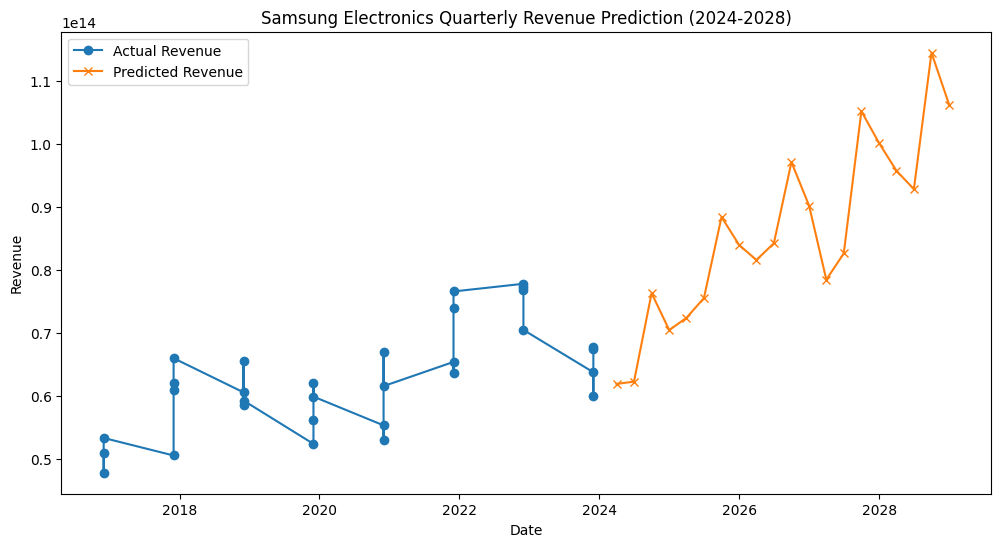

           ds          yhat
0  2024-03-31  6.190091e+13
1  2024-06-30  6.226017e+13
2  2024-09-30  7.629833e+13
3  2024-12-31  7.043666e+13
4  2025-03-31  7.238392e+13
5  2025-06-30  7.550937e+13
6  2025-09-30  8.837935e+13
7  2025-12-31  8.393328e+13
8  2026-03-31  8.155950e+13
9  2026-06-30  8.420338e+13
10 2026-09-30  9.707034e+13
11 2026-12-31  9.017390e+13
12 2027-03-31  7.843775e+13
13 2027-06-30  8.259137e+13
14 2027-09-30  1.051530e+14
15 2027-12-31  1.001171e+14
16 2028-03-31  9.571470e+13
17 2028-06-30  9.278695e+13
18 2028-09-30  1.144282e+14
19 2028-12-31  1.061876e+14


In [6]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, batch_size=1, epochs=200)

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


Epoch 1/200
23/23 [==============================] - 2s 8ms/step - loss: 0.1442
Epoch 2/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0866
Epoch 3/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1034
Epoch 4/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0839
Epoch 5/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0797
Epoch 6/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0676
Epoch 7/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0841
Epoch 8/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0719
Epoch 9/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0763
Epoch 10/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0783
Epoch 11/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0708
Epoch 12/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0726
Epoch 13/200
23/23 [================

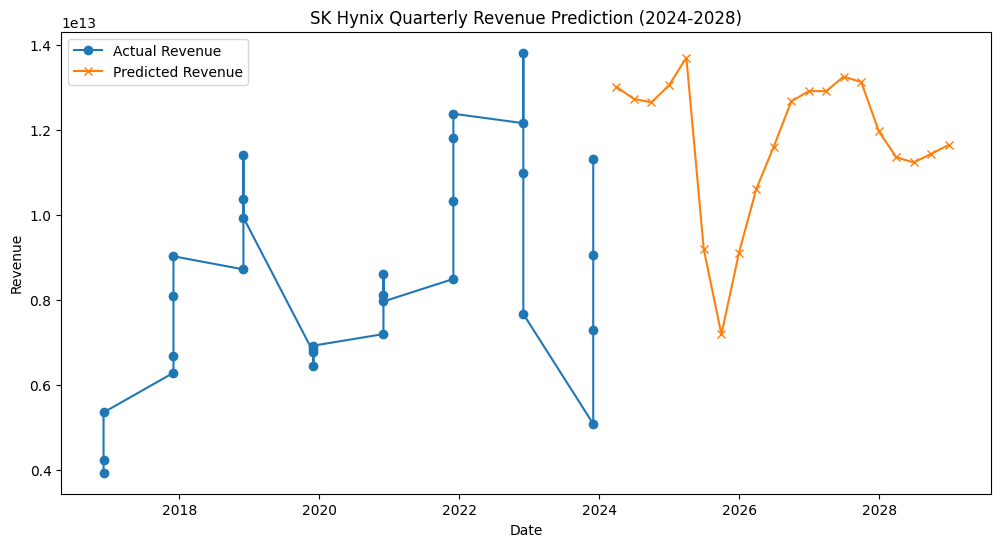

           ds          yhat
0  2024-03-31  1.301159e+13
1  2024-06-30  1.272529e+13
2  2024-09-30  1.264449e+13
3  2024-12-31  1.304894e+13
4  2025-03-31  1.369775e+13
5  2025-06-30  9.191368e+12
6  2025-09-30  7.192814e+12
7  2025-12-31  9.114053e+12
8  2026-03-31  1.060805e+13
9  2026-06-30  1.160219e+13
10 2026-09-30  1.267027e+13
11 2026-12-31  1.290866e+13
12 2027-03-31  1.290684e+13
13 2027-06-30  1.325003e+13
14 2027-09-30  1.312317e+13
15 2027-12-31  1.196203e+13
16 2028-03-31  1.135362e+13
17 2028-06-30  1.123189e+13
18 2028-09-30  1.143616e+13
19 2028-12-31  1.164820e+13


In [8]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '000660'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, batch_size=1, epochs=200)

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SK Hynix Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


In [12]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# TensorFlow의 eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

model.compile(optimizer='adam', loss='mean_squared_error', run_eagerly=True)
model.fit(X, y, batch_size=1, epochs=200)

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Kakao Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


Epoch 1/200


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 [==============================] - 1s 34ms/step - loss: 0.1043
Epoch 2/200
23/23 [==============================] - 1s 34ms/step - loss: 0.0983
Epoch 3/200
23/23 [==============================] - 1s 35ms/step - loss: 0.0654
Epoch 4/200
23/23 [==============================] - 1s 36ms/step - loss: 0.0697
Epoch 5/200
23/23 [==============================] - 1s 35ms/step - loss: 0.0690
Epoch 6/200
23/23 [==============================] - 1s 39ms/step - loss: 0.0724
Epoch 7/200
23/23 [==============================] - 1s 42ms/step - loss: 0.0623
Epoch 8/200
23/23 [==============================] - 1s 44ms/step - loss: 0.0654
Epoch 9/200
23/23 [==============================] - 1s 40ms/step - loss: 0.0664
Epoch 10/200
23/23 [==============================] - 1s 47ms/step - loss: 0.0674
Epoch 11/200
23/23 [==============================] - 1s 44ms/step - loss: 0.0677
Epoch 12/200
23/23 [==============================] - 1s 35ms/step - loss: 0.0629
Epoch 13/200
23/23 [=================

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '108670'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# TensorFlow의 eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

model.compile(optimizer='adam', loss='mean_squared_error', run_eagerly=True)
model.fit(X, y, batch_size=1, epochs=200)

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('LX Hausys Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


Epoch 1/200


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 [==============================] - 1s 54ms/step - loss: 0.7200 - val_loss: 0.5524
Epoch 2/200
18/18 [==============================] - 1s 52ms/step - loss: 0.5129 - val_loss: 0.4398
Epoch 3/200
18/18 [==============================] - 1s 52ms/step - loss: 0.4058 - val_loss: 0.3492
Epoch 4/200
18/18 [==============================] - 1s 52ms/step - loss: 0.3267 - val_loss: 0.2744
Epoch 5/200
18/18 [==============================] - 1s 55ms/step - loss: 0.2621 - val_loss: 0.2245
Epoch 6/200
18/18 [==============================] - 1s 69ms/step - loss: 0.2163 - val_loss: 0.1805
Epoch 7/200
18/18 [==============================] - 1s 65ms/step - loss: 0.1785 - val_loss: 0.1494
Epoch 8/200
18/18 [==============================] - 1s 57ms/step - loss: 0.1600 - val_loss: 0.1230
Epoch 9/200
18/18 [==============================] - 1s 55ms/step - loss: 0.1344 - val_loss: 0.1171
Epoch 10/200
18/18 [==============================] - 1s 61ms/step - loss: 0.1254 - val_loss: 0.0874
Epoch 11/20

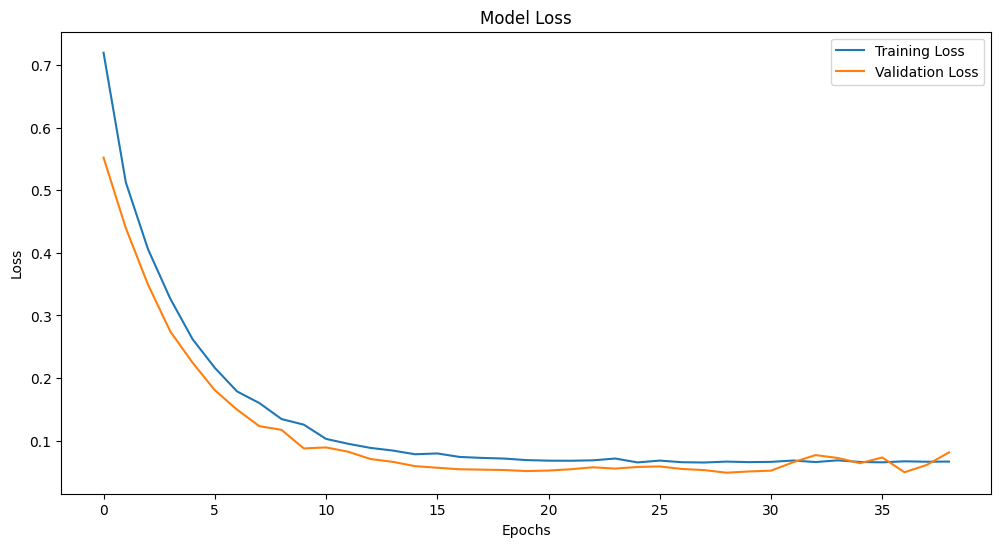

1/1 [==============================] - 0s 34ms/step


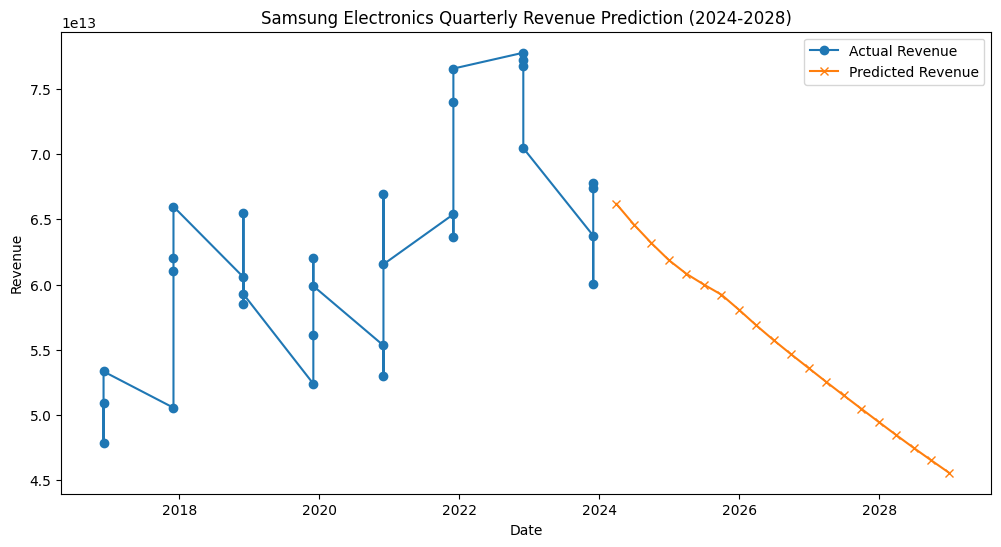

           ds          yhat
0  2024-03-31  6.617994e+13
1  2024-06-30  6.460297e+13
2  2024-09-30  6.316837e+13
3  2024-12-31  6.185538e+13
4  2025-03-31  6.082437e+13
5  2025-06-30  6.000135e+13
6  2025-09-30  5.922195e+13
7  2025-12-31  5.806044e+13
8  2026-03-31  5.686737e+13
9  2026-06-30  5.572884e+13
10 2026-09-30  5.463379e+13
11 2026-12-31  5.357160e+13
12 2027-03-31  5.253090e+13
13 2027-06-30  5.150046e+13
14 2027-09-30  5.047246e+13
15 2027-12-31  4.944824e+13
16 2028-03-31  4.844625e+13
17 2028-06-30  4.746618e+13
18 2028-09-30  4.650616e+13
19 2028-12-31  4.556347e+13


In [3]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(50, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1))

# TensorFlow의 eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', run_eagerly=True)

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=1, callbacks=[early_stop])

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

Epoch 1/200
 3/18 [====>.........................] - ETA: 0s - loss: 0.7324

c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 [==============================] - 1s 54ms/step - loss: 0.7118 - val_loss: 0.5700
Epoch 2/200
18/18 [==============================] - 1s 51ms/step - loss: 0.5303 - val_loss: 0.4560
Epoch 3/200
18/18 [==============================] - 1s 52ms/step - loss: 0.4219 - val_loss: 0.3596
Epoch 4/200
18/18 [==============================] - 1s 50ms/step - loss: 0.3440 - val_loss: 0.2869
Epoch 5/200
18/18 [==============================] - 1s 55ms/step - loss: 0.2785 - val_loss: 0.2290
Epoch 6/200
18/18 [==============================] - 1s 53ms/step - loss: 0.2269 - val_loss: 0.1894
Epoch 7/200
18/18 [==============================] - 1s 51ms/step - loss: 0.1897 - val_loss: 0.1585
Epoch 8/200
18/18 [==============================] - 1s 50ms/step - loss: 0.1654 - val_loss: 0.1277
Epoch 9/200
18/18 [==============================] - 1s 51ms/step - loss: 0.1414 - val_loss: 0.1117
Epoch 10/200
18/18 [==============================] - 1s 50ms/step - loss: 0.1202 - val_loss: 0.0954
Epoch 11/20

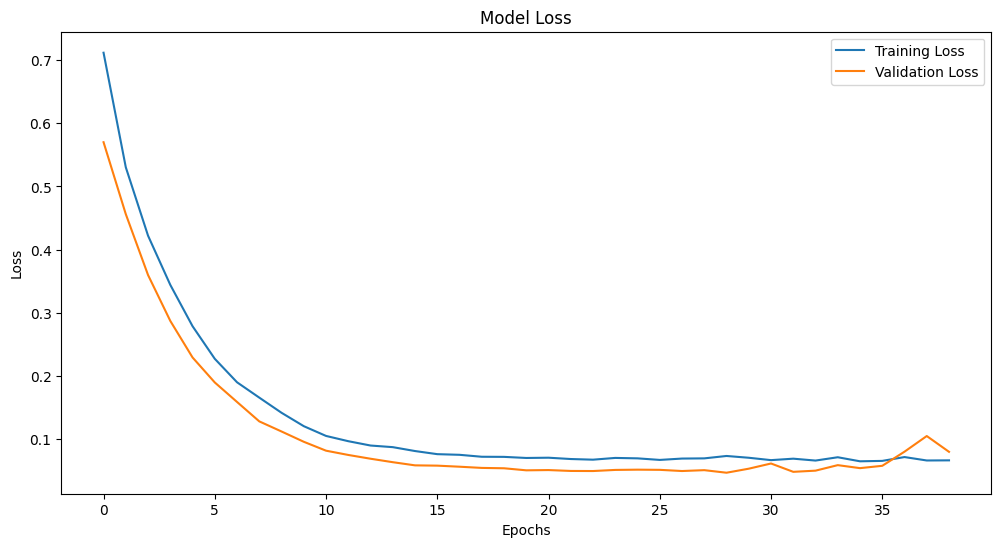

1/1 [==============================] - 0s 30ms/step


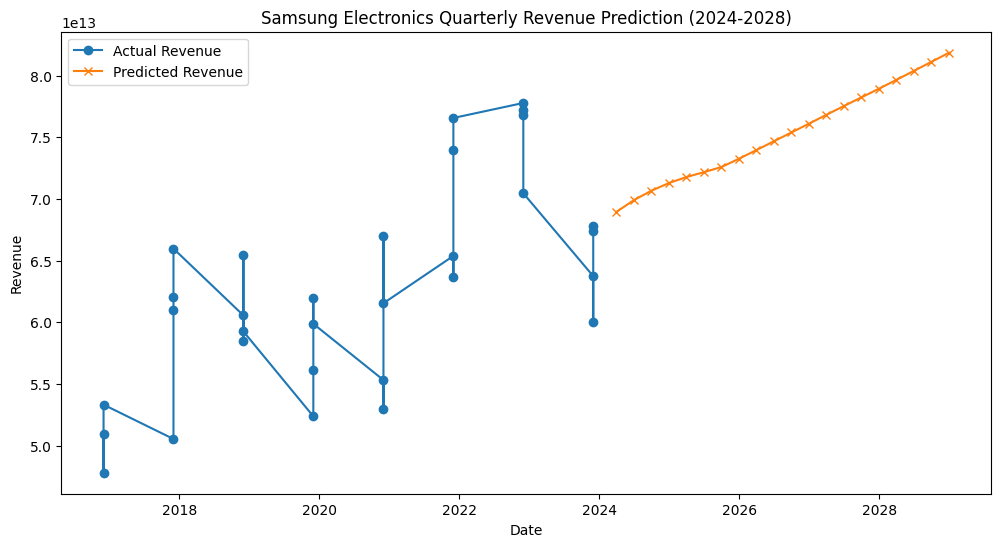

           ds          yhat
0  2024-03-31  6.895165e+13
1  2024-06-30  6.990800e+13
2  2024-09-30  7.067411e+13
3  2024-12-31  7.129777e+13
4  2025-03-31  7.177517e+13
5  2025-06-30  7.217177e+13
6  2025-09-30  7.258794e+13
7  2025-12-31  7.326542e+13
8  2026-03-31  7.395779e+13
9  2026-06-30  7.466974e+13
10 2026-09-30  7.538833e+13
11 2026-12-31  7.610353e+13
12 2027-03-31  7.681525e+13
13 2027-06-30  7.752194e+13
14 2027-09-30  7.822858e+13
15 2027-12-31  7.893416e+13
16 2028-03-31  7.965082e+13
17 2028-06-30  8.037612e+13
18 2028-09-30  8.111128e+13
19 2028-12-31  8.185377e+13


In [4]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(50, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1))

# TensorFlow의 eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', run_eagerly=True)

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=1, callbacks=[early_stop])

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

Epoch 1/200
 3/18 [====>.........................] - ETA: 0s - loss: 0.9070

c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 [==============================] - 1s 57ms/step - loss: 0.7237 - val_loss: 0.7033
Epoch 2/200
18/18 [==============================] - 1s 52ms/step - loss: 0.4875 - val_loss: 0.5567
Epoch 3/200
18/18 [==============================] - 1s 53ms/step - loss: 0.3767 - val_loss: 0.4645
Epoch 4/200
18/18 [==============================] - 1s 52ms/step - loss: 0.2964 - val_loss: 0.3949
Epoch 5/200
18/18 [==============================] - 1s 53ms/step - loss: 0.2334 - val_loss: 0.3382
Epoch 6/200
18/18 [==============================] - 1s 57ms/step - loss: 0.1854 - val_loss: 0.2985
Epoch 7/200
18/18 [==============================] - 1s 55ms/step - loss: 0.1484 - val_loss: 0.2659
Epoch 8/200
18/18 [==============================] - 1s 53ms/step - loss: 0.1200 - val_loss: 0.2454
Epoch 9/200
18/18 [==============================] - 1s 52ms/step - loss: 0.0996 - val_loss: 0.2325
Epoch 10/200
18/18 [==============================] - 1s 53ms/step - loss: 0.0849 - val_loss: 0.2165
Epoch 11/20

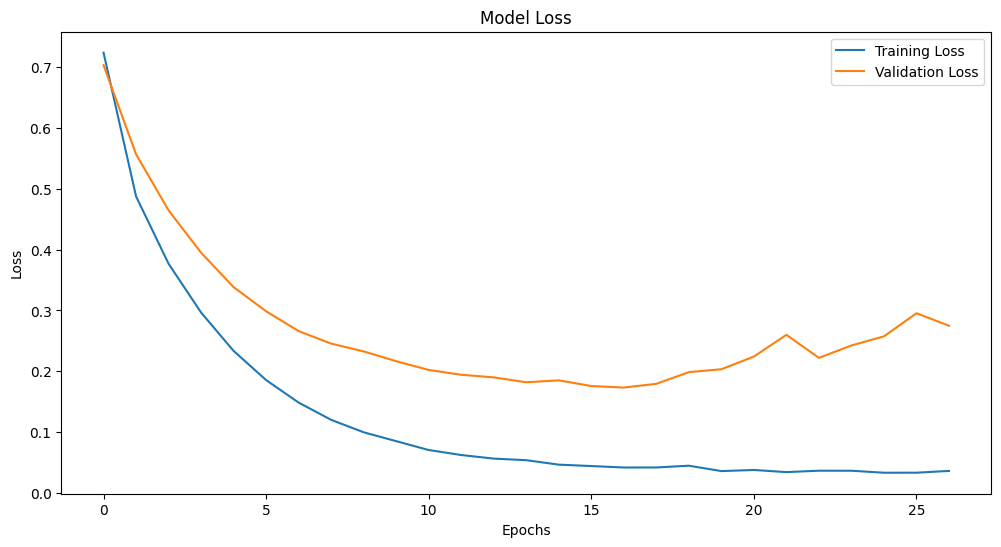

1/1 [==============================] - 0s 35ms/step


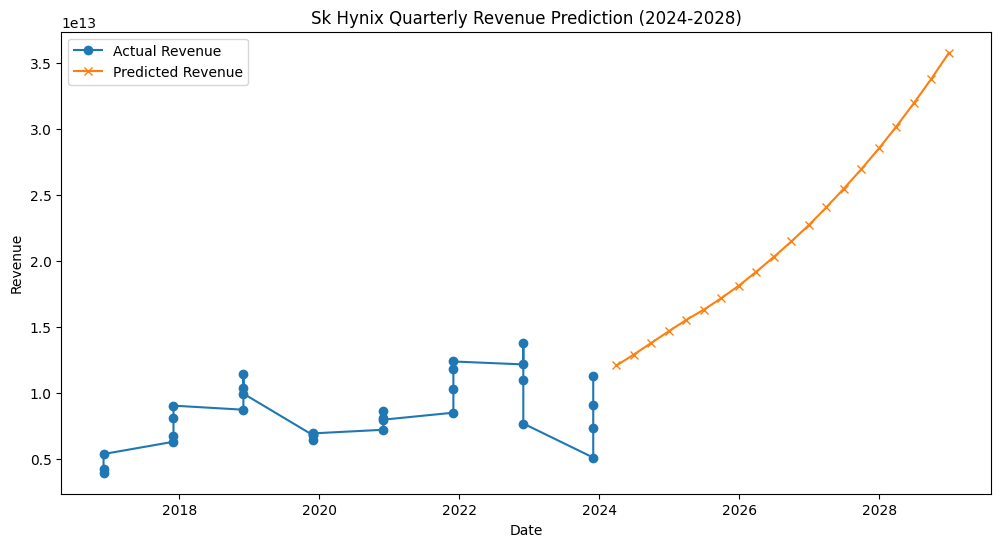

           ds          yhat
0  2024-03-31  1.207556e+13
1  2024-06-30  1.290255e+13
2  2024-09-30  1.379510e+13
3  2024-12-31  1.468591e+13
4  2025-03-31  1.553325e+13
5  2025-06-30  1.630494e+13
6  2025-09-30  1.718027e+13
7  2025-12-31  1.813539e+13
8  2026-03-31  1.918558e+13
9  2026-06-30  2.029805e+13
10 2026-09-30  2.147828e+13
11 2026-12-31  2.273166e+13
12 2027-03-31  2.406033e+13
13 2027-06-30  2.546869e+13
14 2027-09-30  2.695667e+13
15 2027-12-31  2.853065e+13
16 2028-03-31  3.019580e+13
17 2028-06-30  3.195729e+13
18 2028-09-30  3.382153e+13
19 2028-12-31  3.579411e+13


In [5]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '000660'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(50, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1))

# TensorFlow의 eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', run_eagerly=True)

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=1, callbacks=[early_stop])

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Sk Hynix Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

Epoch 1/200
 3/18 [====>.........................] - ETA: 0s - loss: 0.7482

c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 [==============================] - 1s 54ms/step - loss: 0.7199 - val_loss: 0.7026
Epoch 2/200
18/18 [==============================] - 1s 53ms/step - loss: 0.4940 - val_loss: 0.5644
Epoch 3/200
18/18 [==============================] - 1s 54ms/step - loss: 0.3803 - val_loss: 0.4658
Epoch 4/200
18/18 [==============================] - 1s 53ms/step - loss: 0.3009 - val_loss: 0.3974
Epoch 5/200
18/18 [==============================] - 1s 51ms/step - loss: 0.2411 - val_loss: 0.3419
Epoch 6/200
18/18 [==============================] - 1s 48ms/step - loss: 0.1913 - val_loss: 0.2999
Epoch 7/200
18/18 [==============================] - 1s 50ms/step - loss: 0.1549 - val_loss: 0.2734
Epoch 8/200
18/18 [==============================] - 1s 53ms/step - loss: 0.1301 - val_loss: 0.2675
Epoch 9/200
18/18 [==============================] - 1s 51ms/step - loss: 0.1036 - val_loss: 0.2233
Epoch 10/200
18/18 [==============================] - 1s 51ms/step - loss: 0.0881 - val_loss: 0.2202
Epoch 11/20

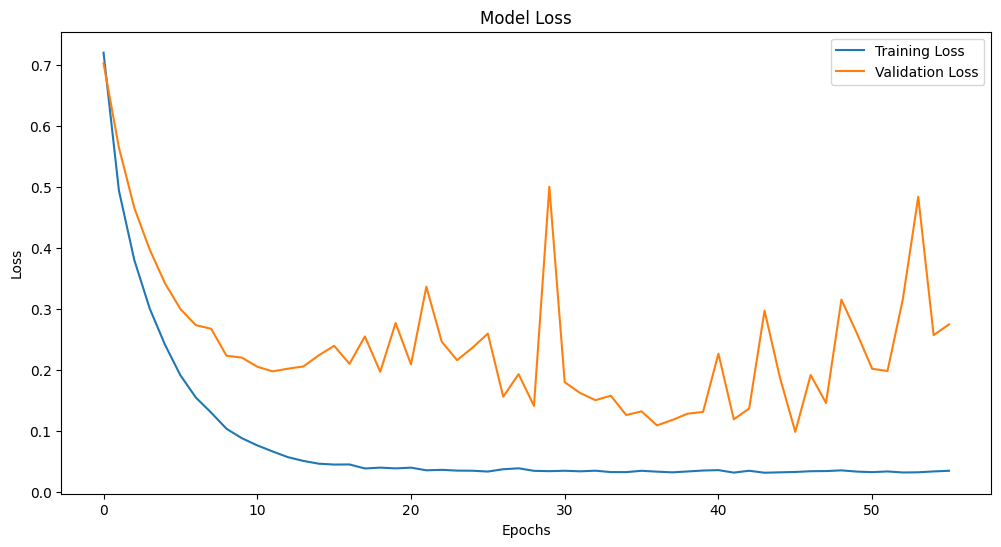

1/1 [==============================] - 0s 32ms/step


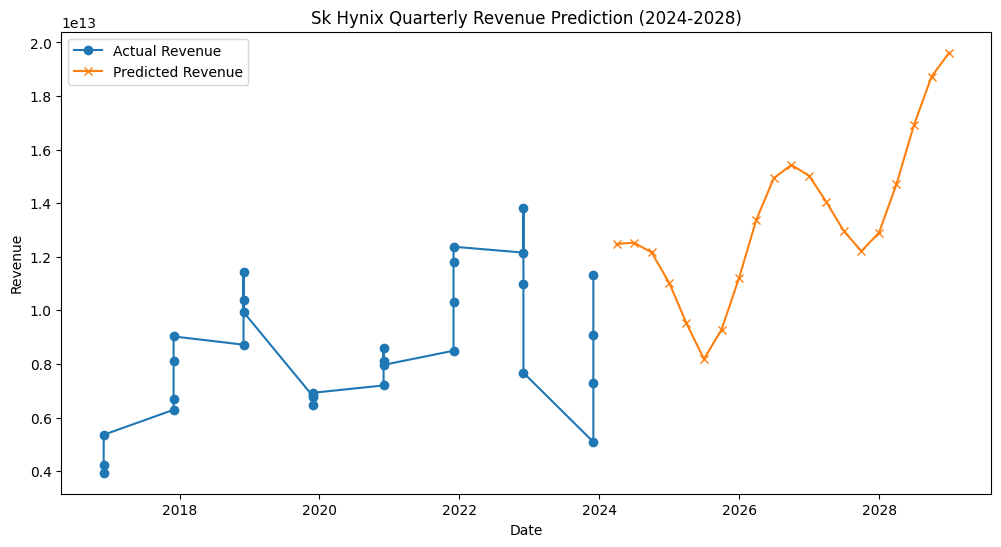

           ds          yhat
0  2024-03-31  1.247765e+13
1  2024-06-30  1.252760e+13
2  2024-09-30  1.216329e+13
3  2024-12-31  1.102449e+13
4  2025-03-31  9.516894e+12
5  2025-06-30  8.183548e+12
6  2025-09-30  9.280862e+12
7  2025-12-31  1.122252e+13
8  2026-03-31  1.338992e+13
9  2026-06-30  1.493693e+13
10 2026-09-30  1.543019e+13
11 2026-12-31  1.502432e+13
12 2027-03-31  1.404799e+13
13 2027-06-30  1.296393e+13
14 2027-09-30  1.221051e+13
15 2027-12-31  1.290100e+13
16 2028-03-31  1.470380e+13
17 2028-06-30  1.690765e+13
18 2028-09-30  1.872372e+13
19 2028-12-31  1.961673e+13


In [6]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '000660'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(50, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1))

# TensorFlow의 eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', run_eagerly=True)

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=1, callbacks=[early_stop])

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Sk Hynix Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

Epoch 1/200
 3/18 [====>.........................] - ETA: 0s - loss: 0.4052

c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 [==============================] - 1s 51ms/step - loss: 0.4154 - val_loss: 0.3200
Epoch 2/200
18/18 [==============================] - 1s 51ms/step - loss: 0.3240 - val_loss: 0.2953
Epoch 3/200
18/18 [==============================] - 1s 49ms/step - loss: 0.2820 - val_loss: 0.2668
Epoch 4/200
18/18 [==============================] - 1s 50ms/step - loss: 0.2496 - val_loss: 0.2289
Epoch 5/200
18/18 [==============================] - 1s 52ms/step - loss: 0.2196 - val_loss: 0.2077
Epoch 6/200
18/18 [==============================] - 1s 50ms/step - loss: 0.2033 - val_loss: 0.1780
Epoch 7/200
18/18 [==============================] - 1s 53ms/step - loss: 0.1813 - val_loss: 0.1938
Epoch 8/200
18/18 [==============================] - 1s 52ms/step - loss: 0.1596 - val_loss: 0.1610
Epoch 9/200
18/18 [==============================] - 1s 52ms/step - loss: 0.1482 - val_loss: 0.1243
Epoch 10/200
18/18 [==============================] - 1s 53ms/step - loss: 0.1327 - val_loss: 0.1313
Epoch 11/20

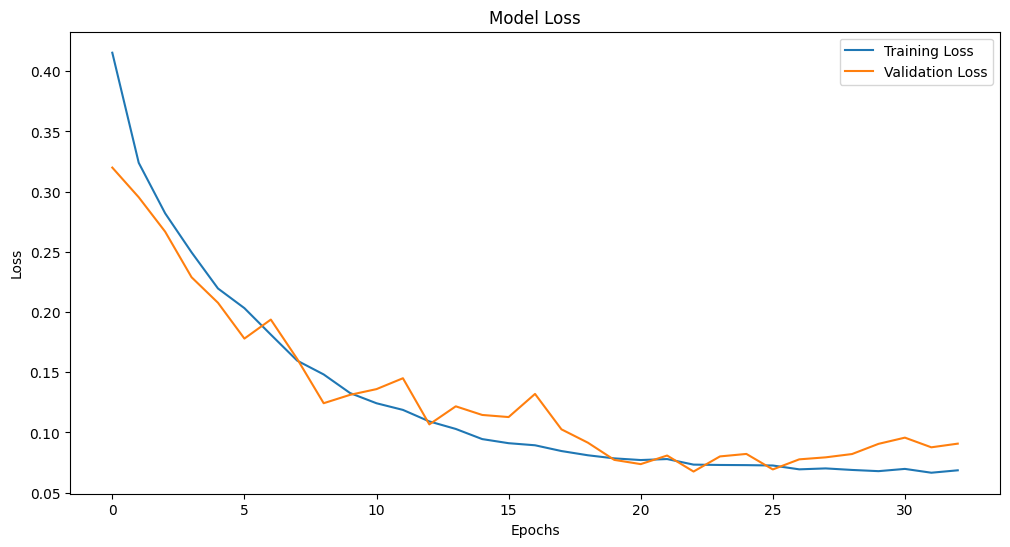

1/1 [==============================] - 0s 31ms/step


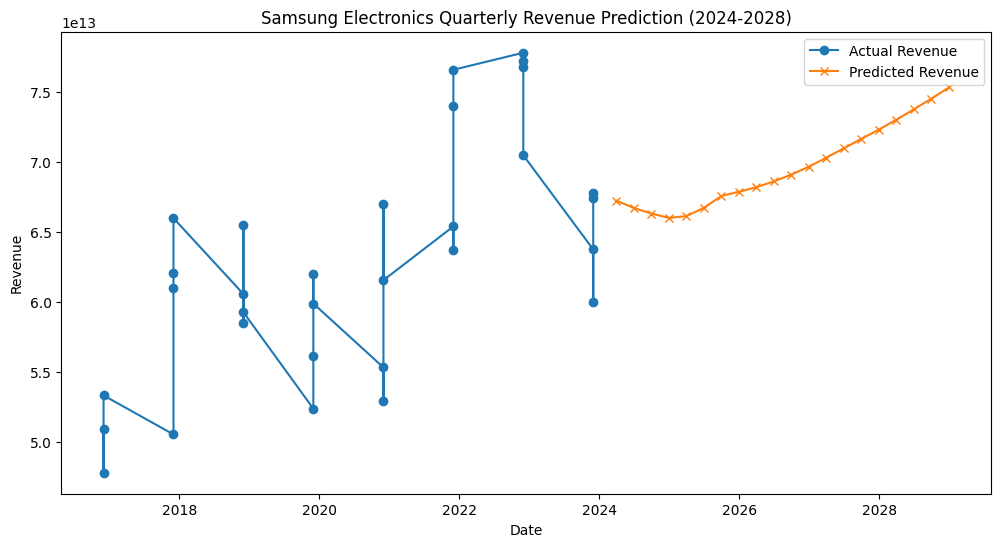

1/1 [==============================] - 0s 30ms/step
Validation Accuracy: 0.20
           ds          yhat
0  2024-03-31  6.722931e+13
1  2024-06-30  6.670343e+13
2  2024-09-30  6.630314e+13
3  2024-12-31  6.599462e+13
4  2025-03-31  6.612561e+13
5  2025-06-30  6.671196e+13
6  2025-09-30  6.756249e+13
7  2025-12-31  6.786198e+13
8  2026-03-31  6.818642e+13
9  2026-06-30  6.859507e+13
10 2026-09-30  6.908955e+13
11 2026-12-31  6.965366e+13
12 2027-03-31  7.028579e+13
13 2027-06-30  7.095633e+13
14 2027-09-30  7.163153e+13
15 2027-12-31  7.229860e+13
16 2028-03-31  7.300202e+13
17 2028-06-30  7.373975e+13
18 2028-09-30  7.450768e+13
19 2028-12-31  7.530028e+13


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [11]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X).reshape(-1, sequence_length, 1)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 경량화된 LSTM 모델 생성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(25, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1))

# TensorFlow의 eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', run_eagerly=True)

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=1, callbacks=[early_stop])

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 정확도 계산
def calculate_accuracy(y_true, y_pred, threshold=0.1):
    return np.mean(np.abs(y_true - y_pred) < threshold)

# 검증 데이터에서의 예측값 생성
y_val_pred = model.predict(X_val)
y_val_true = y_val

# 정확도 계산 및 출력
accuracy = calculate_accuracy(y_val_true, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

Epoch 1/200
 3/18 [====>.........................] - ETA: 0s - loss: 0.5166

c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 [==============================] - 1s 49ms/step - loss: 0.4392 - val_loss: 0.3263
Epoch 2/200
18/18 [==============================] - 1s 54ms/step - loss: 0.3341 - val_loss: 0.2897
Epoch 3/200
18/18 [==============================] - 1s 48ms/step - loss: 0.2898 - val_loss: 0.2687
Epoch 4/200
18/18 [==============================] - 1s 49ms/step - loss: 0.2491 - val_loss: 0.2267
Epoch 5/200
18/18 [==============================] - 1s 51ms/step - loss: 0.2218 - val_loss: 0.2036
Epoch 6/200
18/18 [==============================] - 1s 49ms/step - loss: 0.1980 - val_loss: 0.1806
Epoch 7/200
18/18 [==============================] - 1s 51ms/step - loss: 0.1759 - val_loss: 0.1720
Epoch 8/200
18/18 [==============================] - 1s 49ms/step - loss: 0.1592 - val_loss: 0.1568
Epoch 9/200
18/18 [==============================] - 1s 47ms/step - loss: 0.1465 - val_loss: 0.1306
Epoch 10/200
18/18 [==============================] - 1s 51ms/step - loss: 0.1349 - val_loss: 0.1406
Epoch 11/20

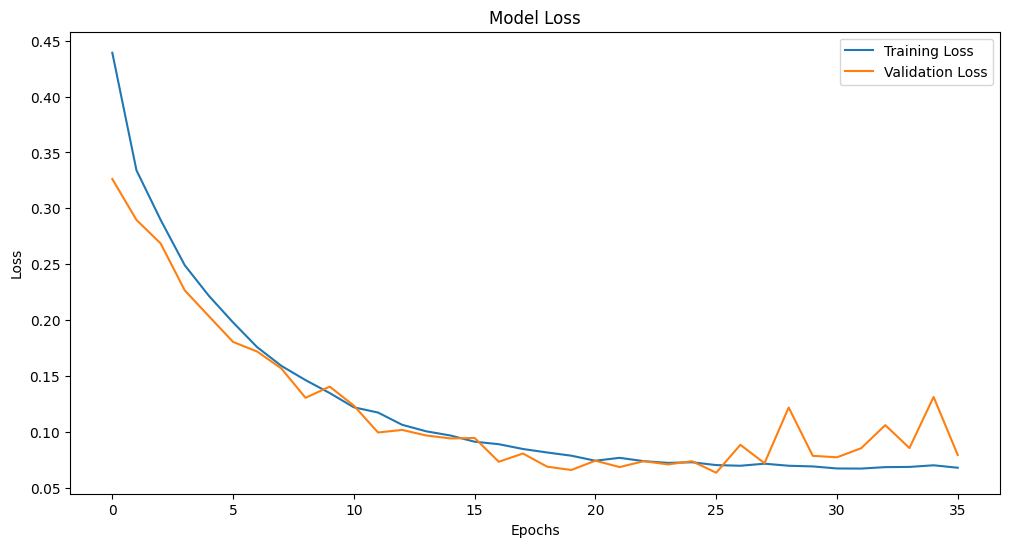

1/1 [==============================] - 0s 32ms/step


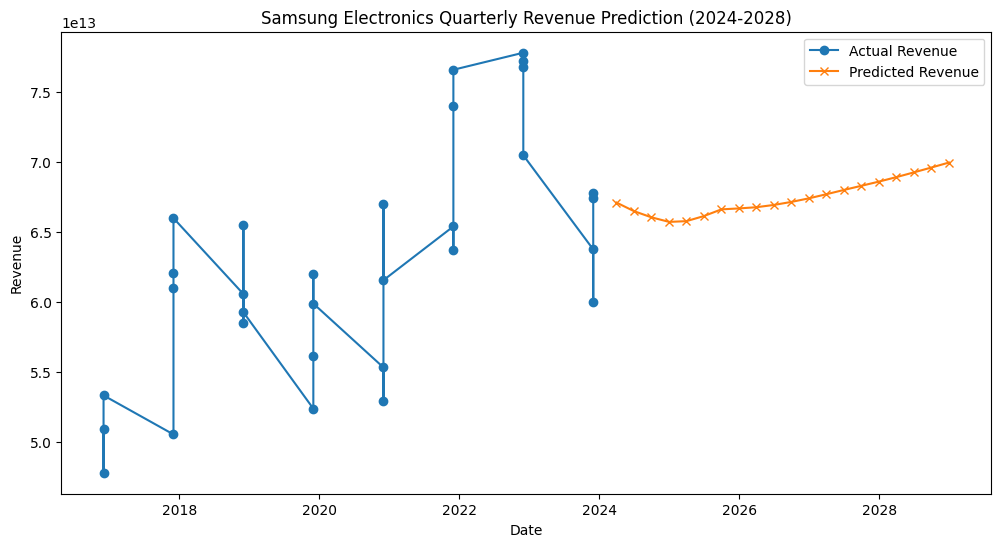

1/1 [==============================] - 0s 33ms/step
Validation Accuracy: 0.20
           ds          yhat
0  2024-03-31  6.709385e+13
1  2024-06-30  6.648217e+13
2  2024-09-30  6.603640e+13
3  2024-12-31  6.571180e+13
4  2025-03-31  6.576338e+13
5  2025-06-30  6.612469e+13
6  2025-09-30  6.660576e+13
7  2025-12-31  6.667270e+13
8  2026-03-31  6.675799e+13
9  2026-06-30  6.691872e+13
10 2026-09-30  6.713617e+13
11 2026-12-31  6.739245e+13
12 2027-03-31  6.768252e+13
13 2027-06-30  6.798586e+13
14 2027-09-30  6.828514e+13
15 2027-12-31  6.858524e+13
16 2028-03-31  6.890468e+13
17 2028-06-30  6.924153e+13
18 2028-09-30  6.959044e+13
19 2028-12-31  6.994641e+13


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [12]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X).reshape(-1, sequence_length, 1)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 경량화된 LSTM 모델 생성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(25, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1))

# TensorFlow의 eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', run_eagerly=True)

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=1, callbacks=[early_stop])

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 정확도 계산
def calculate_accuracy(y_true, y_pred, threshold=0.1):
    return np.mean(np.abs(y_true - y_pred) < threshold)

# 검증 데이터에서의 예측값 생성
y_val_pred = model.predict(X_val)
y_val_true = y_val

# 정확도 계산 및 출력
accuracy = calculate_accuracy(y_val_true, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

In [1]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '000660'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 8
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['growth_rate'].values[i:i + sequence_length])
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X).reshape(-1, sequence_length, 1)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 생성
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 2)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])

# TensorFlow의 eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error', run_eagerly=True)

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=1, callbacks=[early_stop])

# 학습된 모델 저장
model.save('/mnt/data/lstm_model.h5')

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = df['growth_rate'].values[-sequence_length:].reshape((1, sequence_length, 1))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_growth_rate).reshape((1, sequence_length, 1))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SK Hynix Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


Epoch 1/200


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).

Input 0 of layer "lstm" is incompatible with the layer: expected shape=(None, None, 2), found shape=(1, 8, 1)

Call arguments received by layer "sequential" "                 f"(type Sequential):
  • inputs=tf.Tensor(shape=(1, 8, 1), dtype=float32)
  • training=True
  • mask=None

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.8841

c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 167ms/step - loss: 0.8841 - val_loss: 0.5024
Epoch 2/200
1/1 [==============================] - 0s 120ms/step - loss: 2.5865 - val_loss: 0.4839
Epoch 3/200
1/1 [==============================] - 0s 113ms/step - loss: 1.8300 - val_loss: 0.4713
Epoch 4/200
1/1 [==============================] - 0s 115ms/step - loss: 2.5181 - val_loss: 0.4494
Epoch 5/200
1/1 [==============================] - 0s 116ms/step - loss: 1.9709 - val_loss: 0.4332
Epoch 6/200
1/1 [==============================] - 0s 120ms/step - loss: 2.0522 - val_loss: 0.4219
Epoch 7/200
1/1 [==============================] - 0s 115ms/step - loss: 0.8617 - val_loss: 0.4103
Epoch 8/200
1/1 [==============================] - 0s 113ms/step - loss: 1.7151 - val_loss: 0.3987
Epoch 9/200
1/1 [==============================] - 0s 127ms/step - loss: 2.3531 - val_loss: 0.3793
Epoch 10/200
1/1 [==============================] - 0s 155ms/step - loss: 1.5312 - val_loss: 0.3582
Epoch 11/200
1/1 [===

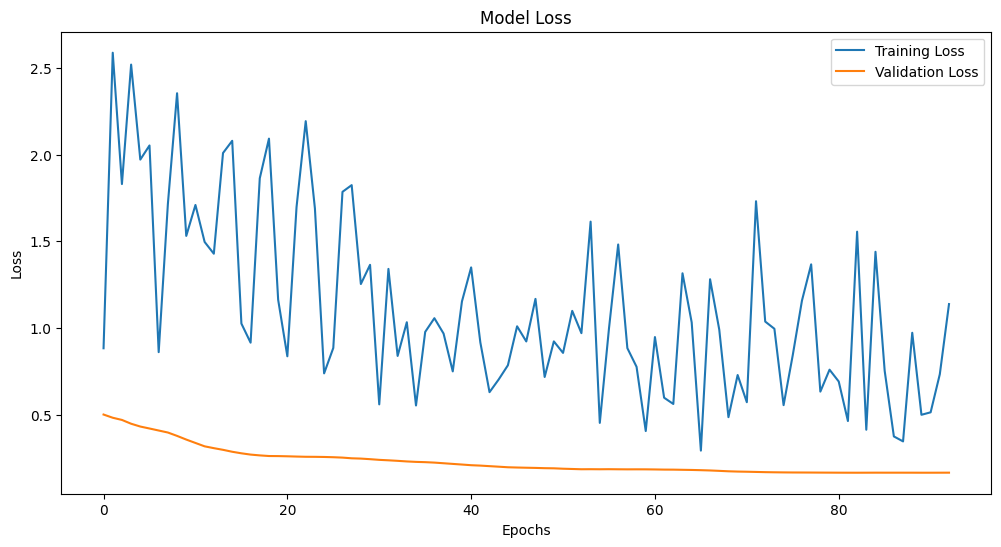

1/1 [==============================] - 0s 60ms/step


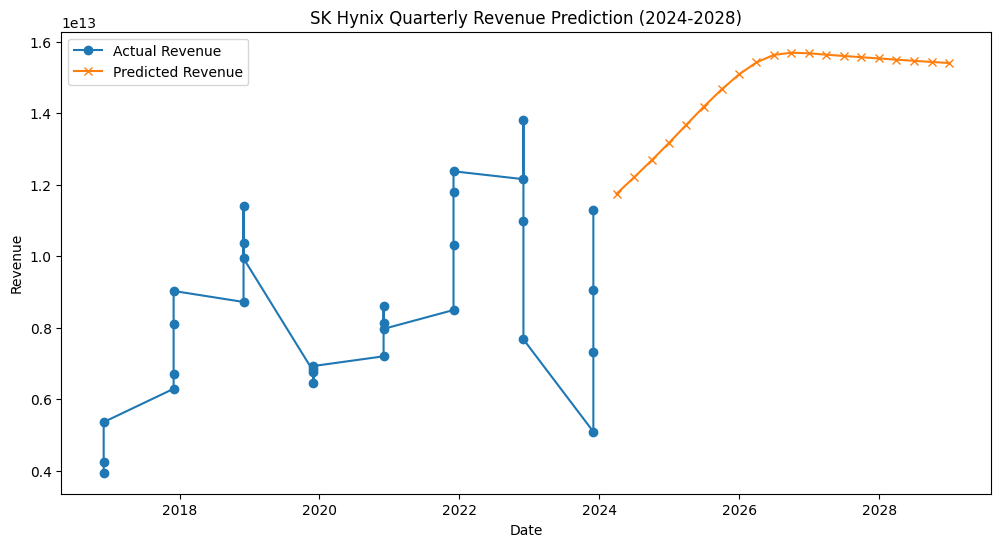

           ds          yhat
0  2024-03-31  1.174679e+13
1  2024-06-30  1.220530e+13
2  2024-09-30  1.268170e+13
3  2024-12-31  1.317670e+13
4  2025-03-31  1.368345e+13
5  2025-06-30  1.418700e+13
6  2025-09-30  1.466536e+13
7  2025-12-31  1.508962e+13
8  2026-03-31  1.542299e+13
9  2026-06-30  1.563337e+13
10 2026-09-30  1.569447e+13
11 2026-12-31  1.567798e+13
12 2027-03-31  1.563959e+13
13 2027-06-30  1.560374e+13
14 2027-09-30  1.556844e+13
15 2027-12-31  1.553387e+13
16 2028-03-31  1.550027e+13
17 2028-06-30  1.546781e+13
18 2028-09-30  1.543663e+13
19 2028-12-31  1.540646e+13


In [19]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '000660'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 10  # 시퀀스 길이 증가
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 생성
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, 2)),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=16, callbacks=[early_stop])

# 학습된 모델 저장
model.save('/mnt/data/lstm_model.h5')

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    next_sequence = np.append(current_sequence[0, 1:], [[predicted_growth_rate[0, 0], (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 이동 평균을 적용하여 변동성 줄이기
future_growth_rates_smooth = pd.Series(future_growth_rates.flatten()).rolling(window=4).mean().fillna(method='bfill').values

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates_smooth.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SK Hynix Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


1/1 [==============================] - 0s 46ms/step


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


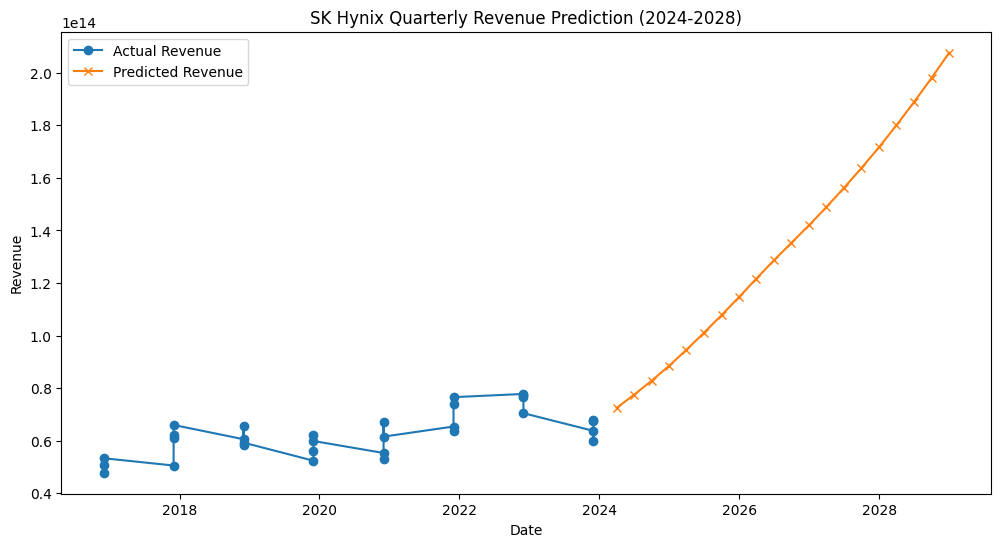

           ds          yhat
0  2024-03-31  7.245776e+13
1  2024-06-30  7.745843e+13
2  2024-09-30  8.280421e+13
3  2024-12-31  8.851893e+13
4  2025-03-31  9.460307e+13
5  2025-06-30  1.010299e+14
6  2025-09-30  1.077467e+14
7  2025-12-31  1.146692e+14
8  2026-03-31  1.216704e+14
9  2026-06-30  1.285936e+14
10 2026-09-30  1.352840e+14
11 2026-12-31  1.419722e+14
12 2027-03-31  1.488628e+14
13 2027-06-30  1.560950e+14
14 2027-09-30  1.636811e+14
15 2027-12-31  1.716391e+14
16 2028-03-31  1.799884e+14
17 2028-06-30  1.887502e+14
18 2028-09-30  1.979454e+14
19 2028-12-31  2.075944e+14


In [22]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '005930'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 10  # 시퀀스 길이 증가
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    next_sequence = np.append(current_sequence[0, 1:], [[predicted_growth_rate[0, 0], (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 이동 평균을 적용하여 변동성 줄이기
future_growth_rates_smooth = pd.Series(future_growth_rates.flatten()).rolling(window=4).mean().fillna(method='bfill').values

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates_smooth.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SK Hynix Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])



Epoch 1/200
1/1 [==============================] - 0s 136ms/step - loss: 0.3309 - val_loss: 0.0808


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 2/200
1/1 [==============================] - 0s 84ms/step - loss: 0.1234 - val_loss: 0.0405
Epoch 3/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0727 - val_loss: 0.0781
Epoch 4/200
1/1 [==============================] - 0s 75ms/step - loss: 0.1704 - val_loss: 0.0871
Epoch 5/200
1/1 [==============================] - 0s 81ms/step - loss: 0.1275 - val_loss: 0.0725
Epoch 6/200
1/1 [==============================] - 0s 77ms/step - loss: 0.1167 - val_loss: 0.0534
Epoch 7/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0872 - val_loss: 0.0413
Epoch 8/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0875 - val_loss: 0.0395
Epoch 9/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0770 - val_loss: 0.0465
Epoch 10/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0924 - val_loss: 0.0559
Epoch 11/200
1/1 [==============================] - 0s 80ms/step - loss: 0.1067 - val_loss: 0.0619
Epoch 12/200
1/1 [

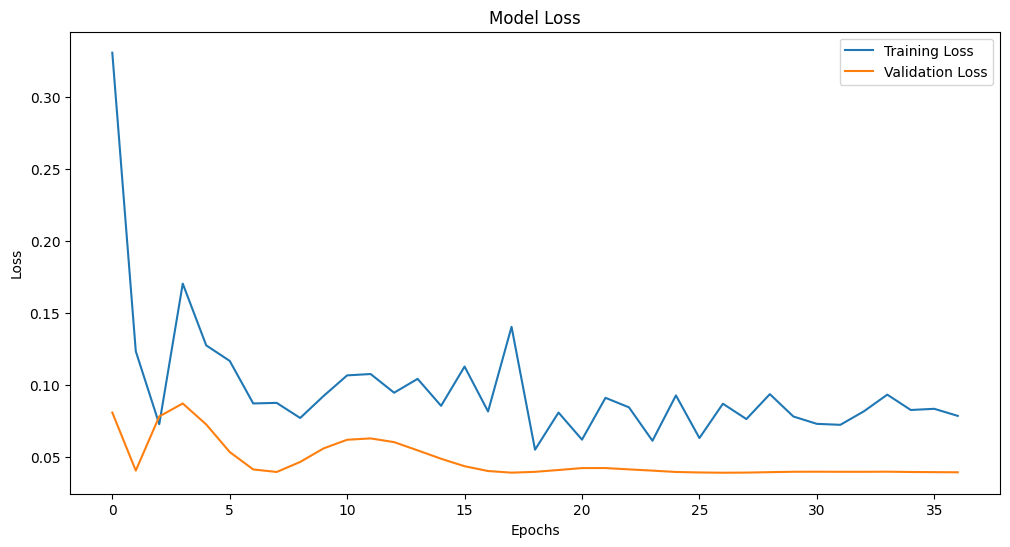

1/1 [==============================] - 0s 32ms/step


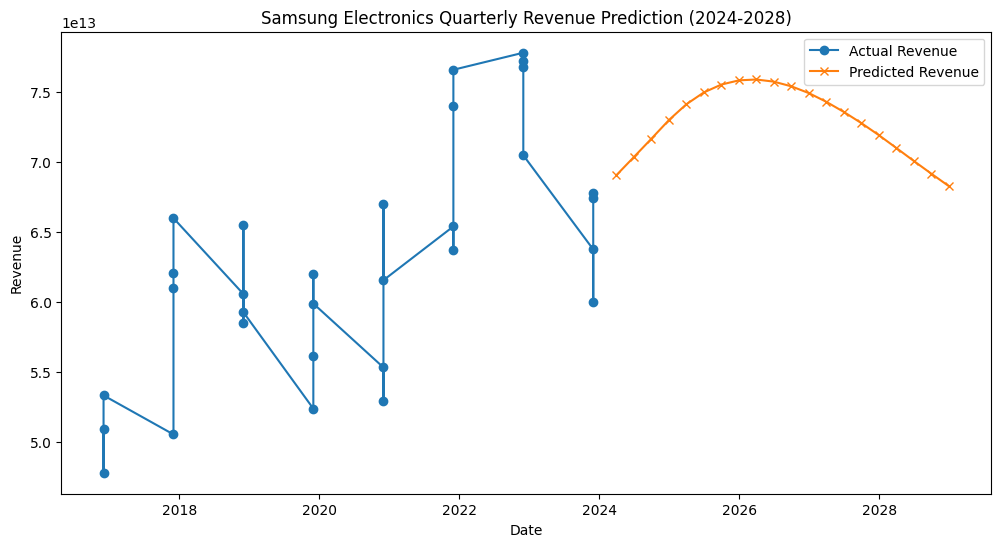

           ds          yhat
0  2024-03-31  6.904664e+13
1  2024-06-30  7.033701e+13
2  2024-09-30  7.165150e+13
3  2024-12-31  7.299055e+13
4  2025-03-31  7.410251e+13
5  2025-06-30  7.494643e+13
6  2025-09-30  7.551178e+13
7  2025-12-31  7.581107e+13
8  2026-03-31  7.587104e+13
9  2026-06-30  7.571927e+13
10 2026-09-30  7.538480e+13
11 2026-12-31  7.489744e+13
12 2027-03-31  7.428304e+13
13 2027-06-30  7.356549e+13
14 2027-09-30  7.276469e+13
15 2027-12-31  7.189888e+13
16 2028-03-31  7.098584e+13
17 2028-06-30  7.006163e+13
18 2028-09-30  6.914796e+13
19 2028-12-31  6.825388e+13


In [48]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '005930'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 16  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 생성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 2)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=16, callbacks=[early_stop])

# 학습된 모델 저장
model.save('/mnt/data/lstm_model.h5')

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    next_sequence = np.append(current_sequence[0, 1:], [[predicted_growth_rate[0, 0], (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 이동 평균을 적용하여 변동성 줄이기
future_growth_rates_smooth = pd.Series(future_growth_rates.flatten()).rolling(window=4).mean().fillna(method='bfill').values

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates_smooth.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


1/1 [==============================] - 0s 30ms/step


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 30ms/step


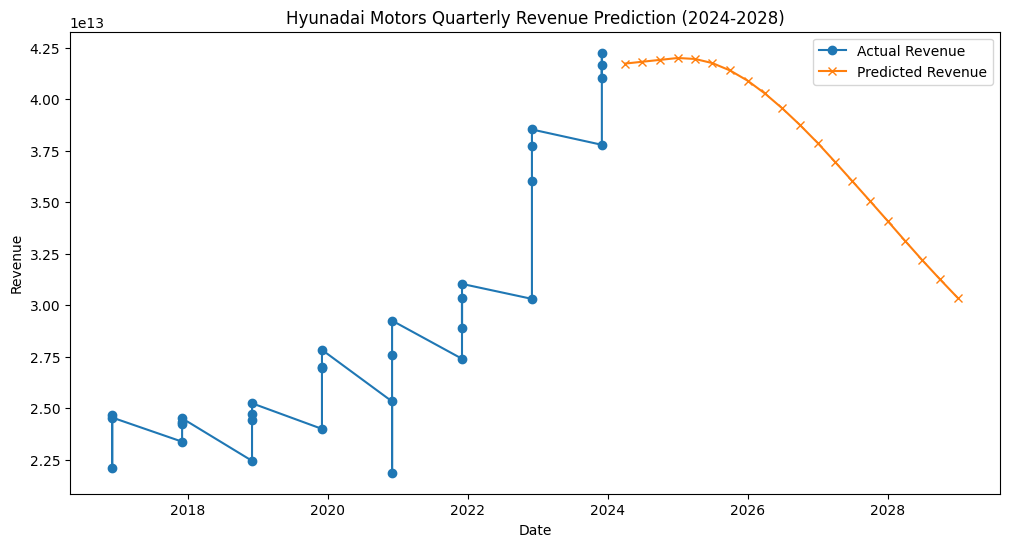

           ds          yhat
0  2024-03-31  4.172246e+13
1  2024-06-30  4.181259e+13
2  2024-09-30  4.190291e+13
3  2024-12-31  4.199342e+13
4  2025-03-31  4.194735e+13
5  2025-06-30  4.174614e+13
6  2025-09-30  4.138888e+13
7  2025-12-31  4.089089e+13
8  2026-03-31  4.027039e+13
9  2026-06-30  3.954720e+13
10 2026-09-30  3.874107e+13
11 2026-12-31  3.787262e+13
12 2027-03-31  3.696019e+13
13 2027-06-30  3.601772e+13
14 2027-09-30  3.505801e+13
15 2027-12-31  3.409045e+13
16 2028-03-31  3.312276e+13
17 2028-06-30  3.217216e+13
18 2028-09-30  3.124779e+13
19 2028-12-31  3.035205e+13


In [49]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '005380'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 16  # 시퀀스 길이 증가
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)
    future_growth_rates.append(predicted_growth_rate[0, 0])
    next_sequence = np.append(current_sequence[0, 1:], [[predicted_growth_rate[0, 0], (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 이동 평균을 적용하여 변동성 줄이기
future_growth_rates_smooth = pd.Series(future_growth_rates.flatten()).rolling(window=4).mean().fillna(method='bfill').values

# 예측된 성장률 기반으로 매출액 계산
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates_smooth.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Hyunadai Motors Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])



Epoch 1/200
1/1 [==============================] - 0s 132ms/step - loss: 0.9540 - val_loss: 0.5921
Epoch 2/200


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 91ms/step - loss: 0.6364 - val_loss: 0.3172
Epoch 3/200
1/1 [==============================] - 0s 77ms/step - loss: 0.3001 - val_loss: 0.1445
Epoch 4/200
1/1 [==============================] - 0s 78ms/step - loss: 0.1742 - val_loss: 0.0572
Epoch 5/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0923 - val_loss: 0.0404
Epoch 6/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0622 - val_loss: 0.0699
Epoch 7/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0983 - val_loss: 0.1069
Epoch 8/200
1/1 [==============================] - 0s 75ms/step - loss: 0.1491 - val_loss: 0.1277
Epoch 9/200
1/1 [==============================] - 0s 81ms/step - loss: 0.2369 - val_loss: 0.1217
Epoch 10/200
1/1 [==============================] - 0s 82ms/step - loss: 0.1427 - val_loss: 0.1050
Epoch 11/200
1/1 [==============================] - 0s 80ms/step - loss: 0.1439 - val_loss: 0.0841
Epoch 12/200
1/1 [============

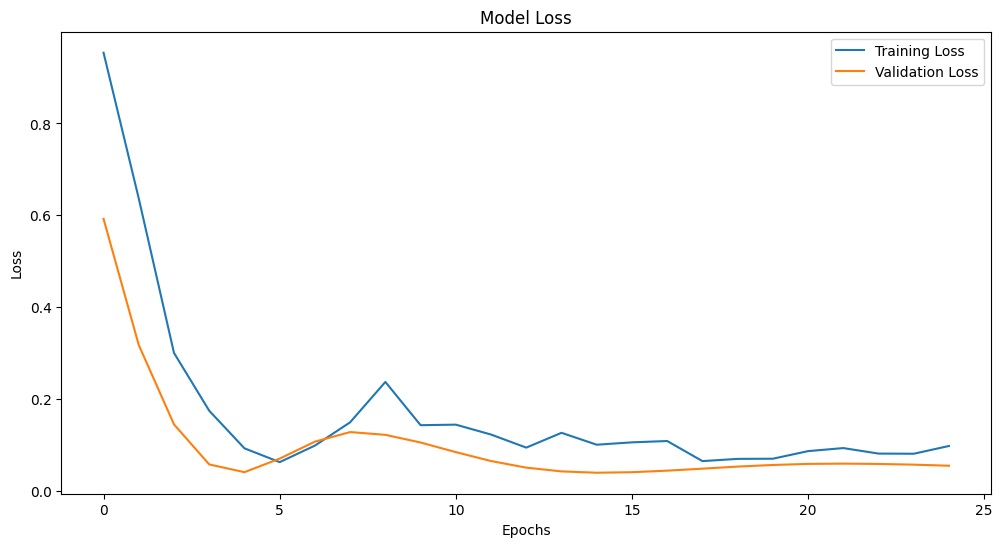

1/1 [==============================] - 0s 28ms/step


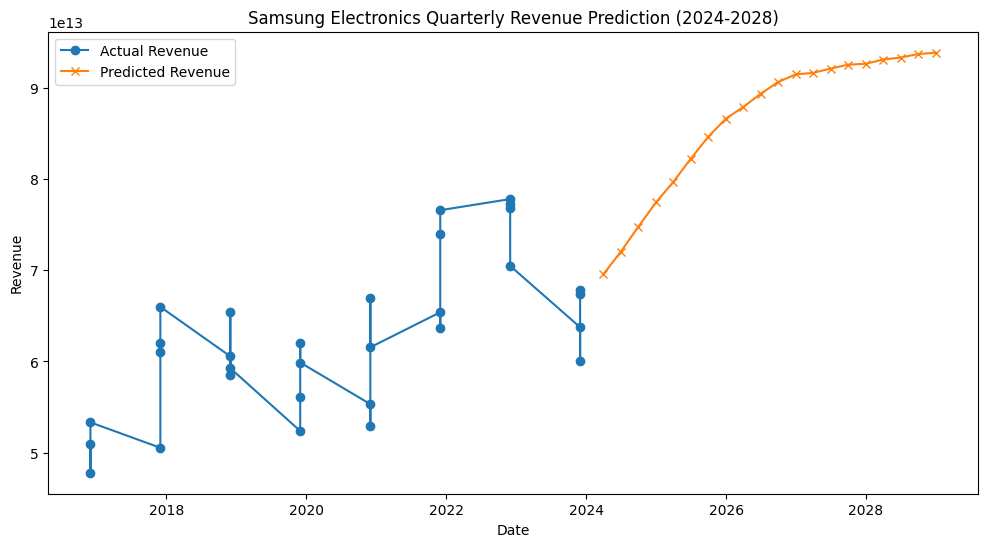

           ds          yhat
0  2024-03-31  6.953965e+13
1  2024-06-30  7.200315e+13
2  2024-09-30  7.475564e+13
3  2024-12-31  7.742053e+13
4  2025-03-31  7.965312e+13
5  2025-06-30  8.218001e+13
6  2025-09-30  8.461077e+13
7  2025-12-31  8.659190e+13
8  2026-03-31  8.785454e+13
9  2026-06-30  8.930956e+13
10 2026-09-30  9.060602e+13
11 2026-12-31  9.144336e+13
12 2027-03-31  9.160344e+13
13 2027-06-30  9.207107e+13
14 2027-09-30  9.250039e+13
15 2027-12-31  9.260030e+13
16 2028-03-31  9.306330e+13
17 2028-06-30  9.328355e+13
18 2028-09-30  9.366769e+13
19 2028-12-31  9.381024e+13


In [73]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '005930'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제
# 표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 16  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 생성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 2)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# EarlyStopping 콜백 추가
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=16, callbacks=[early_stop])

# 학습된 모델 저장
model.save('/mnt/data/lstm_model.h5')

# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

# 기본 성장률 설정 (예: 분기별 최소 0.5% 성장)
base_growth_rate = 0.005

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)[0, 0]
    # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
    adjusted_growth_rate = max(predicted_growth_rate, base_growth_rate)
    future_growth_rates.append(adjusted_growth_rate)
    next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 매출액이 항상 증가하도록 보정
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    if next_revenue < last_revenue:  # 매출액이 감소하지 않도록 조정
        next_revenue = last_revenue * (1 + base_growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


1/1 [==============================] - 0s 32ms/step


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


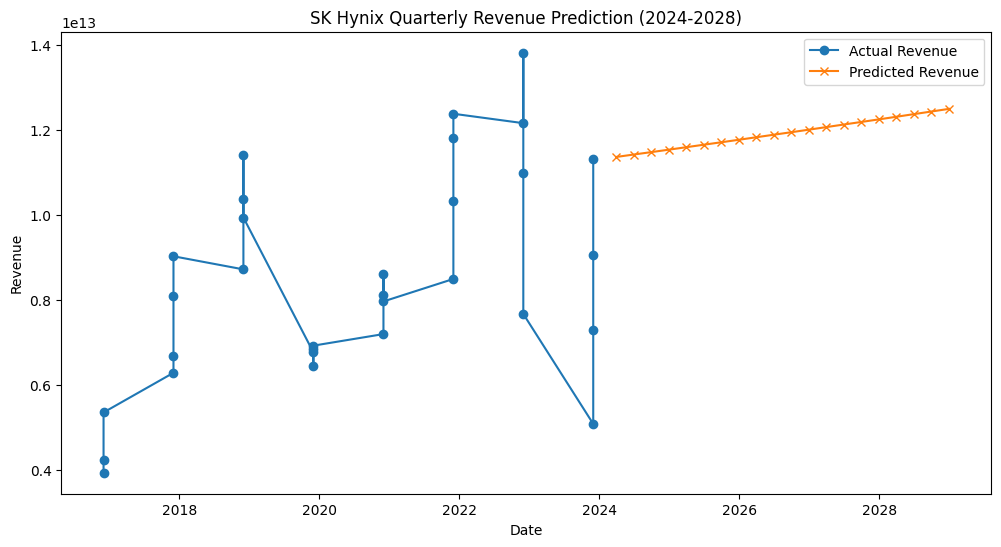

           ds          yhat
0  2024-03-31  1.136203e+13
1  2024-06-30  1.141884e+13
2  2024-09-30  1.147594e+13
3  2024-12-31  1.153332e+13
4  2025-03-31  1.159098e+13
5  2025-06-30  1.164894e+13
6  2025-09-30  1.170718e+13
7  2025-12-31  1.176572e+13
8  2026-03-31  1.182455e+13
9  2026-06-30  1.188367e+13
10 2026-09-30  1.194309e+13
11 2026-12-31  1.200280e+13
12 2027-03-31  1.206282e+13
13 2027-06-30  1.212313e+13
14 2027-09-30  1.218375e+13
15 2027-12-31  1.224467e+13
16 2028-03-31  1.230589e+13
17 2028-06-30  1.236742e+13
18 2028-09-30  1.242926e+13
19 2028-12-31  1.249140e+13


In [84]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '000660'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제
# 표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 16  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

# 기본 성장률 설정 (예: 분기별 최소 0.5% 성장)
base_growth_rate = 0.005

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)[0, 0]
    # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
    adjusted_growth_rate = max(predicted_growth_rate, base_growth_rate)
    future_growth_rates.append(adjusted_growth_rate)
    next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 매출액이 항상 증가하도록 보정
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    if next_revenue < last_revenue:  # 매출액이 감소하지 않도록 조정
        next_revenue = last_revenue * (1 + base_growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SK Hynix Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

1/1 [==============================] - 0s 33ms/step


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


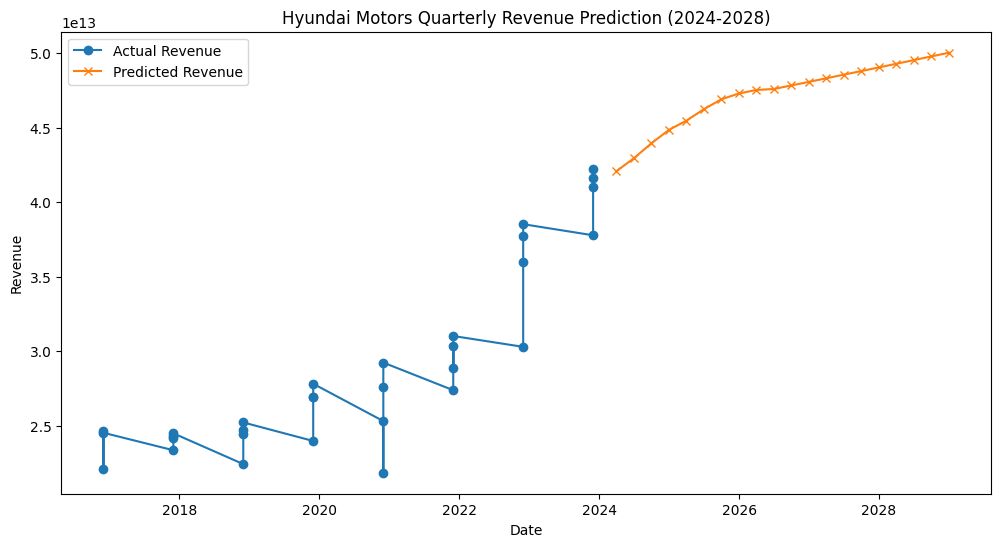

           ds          yhat
0  2024-03-31  4.207036e+13
1  2024-06-30  4.293608e+13
2  2024-09-30  4.394182e+13
3  2024-12-31  4.484810e+13
4  2025-03-31  4.545675e+13
5  2025-06-30  4.622127e+13
6  2025-09-30  4.689498e+13
7  2025-12-31  4.728578e+13
8  2026-03-31  4.752221e+13
9  2026-06-30  4.758605e+13
10 2026-09-30  4.782398e+13
11 2026-12-31  4.806310e+13
12 2027-03-31  4.830341e+13
13 2027-06-30  4.854493e+13
14 2027-09-30  4.878766e+13
15 2027-12-31  4.903159e+13
16 2028-03-31  4.927675e+13
17 2028-06-30  4.952314e+13
18 2028-09-30  4.977075e+13
19 2028-12-31  5.001960e+13


In [85]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '005380'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제
# 표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 16  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

# 기본 성장률 설정 (예: 분기별 최소 0.5% 성장)
base_growth_rate = 0.005

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)[0, 0]
    # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
    adjusted_growth_rate = max(predicted_growth_rate, base_growth_rate)
    future_growth_rates.append(adjusted_growth_rate)
    next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 매출액이 항상 증가하도록 보정
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    if next_revenue < last_revenue:  # 매출액이 감소하지 않도록 조정
        next_revenue = last_revenue * (1 + base_growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Hyundai Motors Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

1/1 [==============================] - ETA: 0s

c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


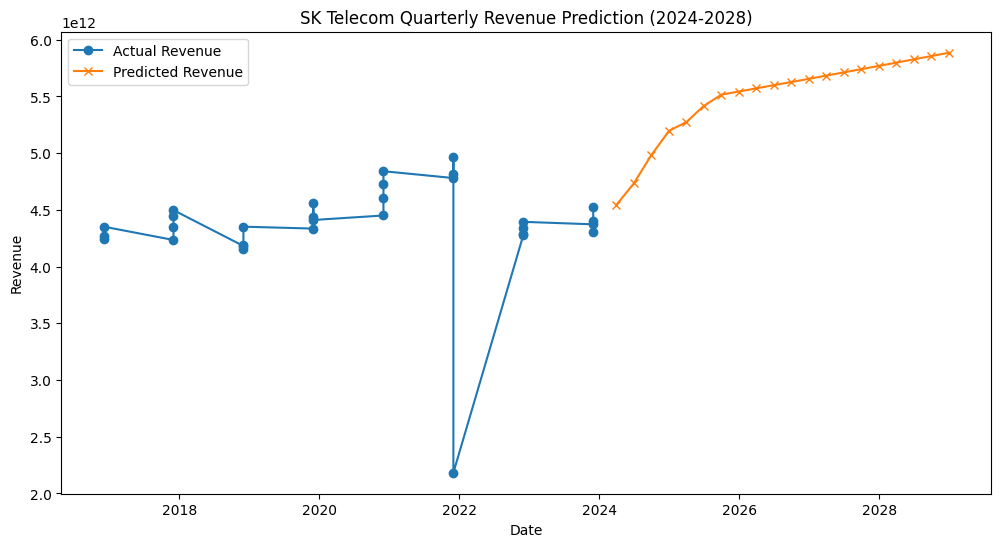

           ds          yhat
0  2024-03-31  4.543753e+12
1  2024-06-30  4.733822e+12
2  2024-09-30  4.984781e+12
3  2024-12-31  5.197053e+12
4  2025-03-31  5.273971e+12
5  2025-06-30  5.415996e+12
6  2025-09-30  5.515858e+12
7  2025-12-31  5.543437e+12
8  2026-03-31  5.571154e+12
9  2026-06-30  5.599010e+12
10 2026-09-30  5.627005e+12
11 2026-12-31  5.655140e+12
12 2027-03-31  5.683416e+12
13 2027-06-30  5.711833e+12
14 2027-09-30  5.740392e+12
15 2027-12-31  5.769094e+12
16 2028-03-31  5.797939e+12
17 2028-06-30  5.826929e+12
18 2028-09-30  5.856064e+12
19 2028-12-31  5.885344e+12


In [86]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '017670'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제
# 표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 16  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

# 기본 성장률 설정 (예: 분기별 최소 0.5% 성장)
base_growth_rate = 0.005

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)[0, 0]
    # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
    adjusted_growth_rate = max(predicted_growth_rate, base_growth_rate)
    future_growth_rates.append(adjusted_growth_rate)
    next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 매출액이 항상 증가하도록 보정
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    if next_revenue < last_revenue:  # 매출액이 감소하지 않도록 조정
        next_revenue = last_revenue * (1 + base_growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SK Telecom Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

1/1 [==============================] - 0s 27ms/step


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


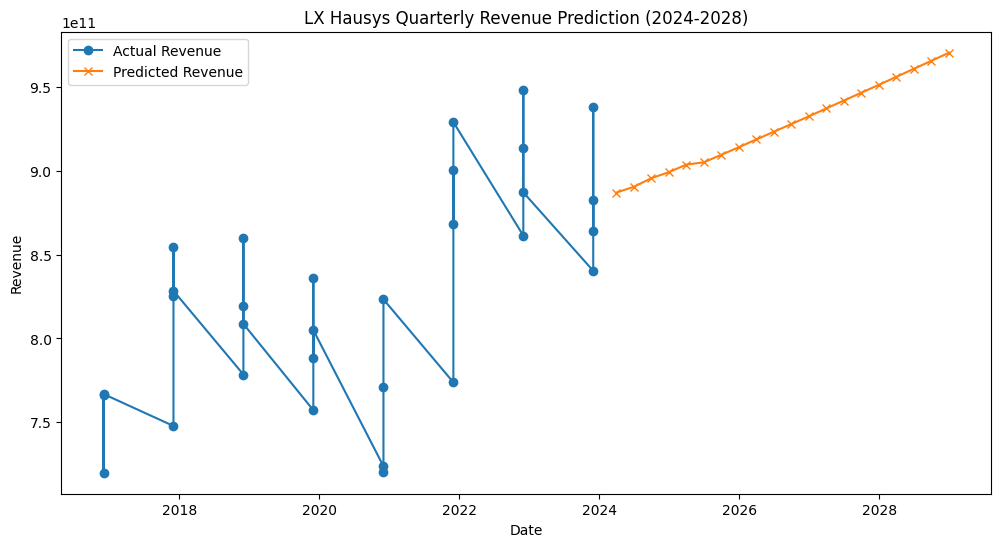

           ds          yhat
0  2024-03-31  8.871266e+11
1  2024-06-30  8.905631e+11
2  2024-09-30  8.957283e+11
3  2024-12-31  8.993474e+11
4  2025-03-31  9.038441e+11
5  2025-06-30  9.051763e+11
6  2025-09-30  9.097022e+11
7  2025-12-31  9.142507e+11
8  2026-03-31  9.188219e+11
9  2026-06-30  9.234160e+11
10 2026-09-30  9.280331e+11
11 2026-12-31  9.326733e+11
12 2027-03-31  9.373367e+11
13 2027-06-30  9.420233e+11
14 2027-09-30  9.467335e+11
15 2027-12-31  9.514671e+11
16 2028-03-31  9.562245e+11
17 2028-06-30  9.610056e+11
18 2028-09-30  9.658106e+11
19 2028-12-31  9.706397e+11


In [87]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '108670'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제
# 표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 16  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

# 기본 성장률 설정 (예: 분기별 최소 0.5% 성장)
base_growth_rate = 0.005

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)[0, 0]
    # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
    adjusted_growth_rate = max(predicted_growth_rate, base_growth_rate)
    future_growth_rates.append(adjusted_growth_rate)
    next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 매출액이 항상 증가하도록 보정
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    if next_revenue < last_revenue:  # 매출액이 감소하지 않도록 조정
        next_revenue = last_revenue * (1 + base_growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('LX Hausys Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

1/1 [==============================] - 0s 28ms/step


c:\Users\SKT01\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


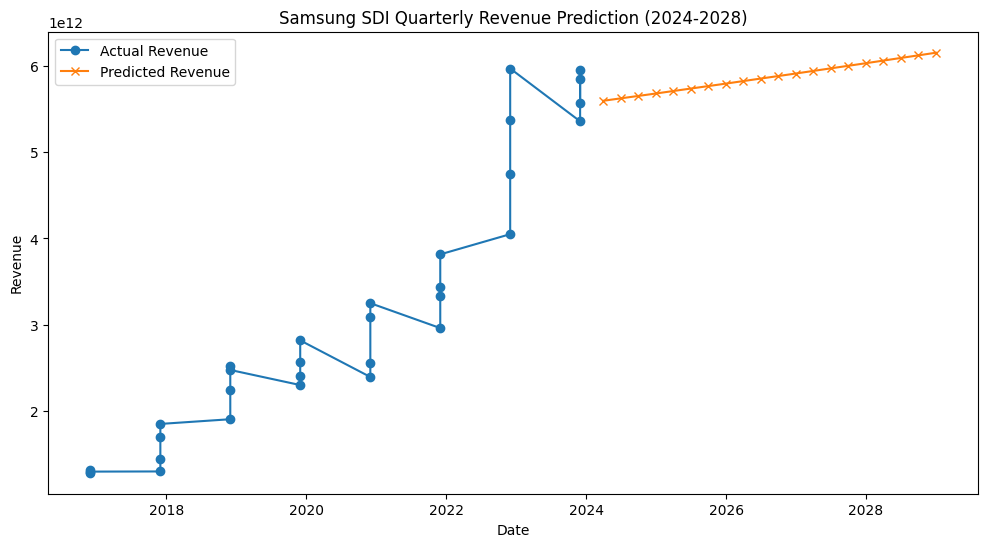

           ds          yhat
0  2024-03-31  5.592589e+12
1  2024-06-30  5.620552e+12
2  2024-09-30  5.648655e+12
3  2024-12-31  5.676898e+12
4  2025-03-31  5.705282e+12
5  2025-06-30  5.733809e+12
6  2025-09-30  5.762478e+12
7  2025-12-31  5.791290e+12
8  2026-03-31  5.820247e+12
9  2026-06-30  5.849348e+12
10 2026-09-30  5.878595e+12
11 2026-12-31  5.907988e+12
12 2027-03-31  5.937528e+12
13 2027-06-30  5.967215e+12
14 2027-09-30  5.997051e+12
15 2027-12-31  6.027036e+12
16 2028-03-31  6.057172e+12
17 2028-06-30  6.087458e+12
18 2028-09-30  6.117895e+12
19 2028-12-31  6.148484e+12


In [88]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '006400'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제
# 표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 성장률 계산
df['growth_rate'] = df['y'].pct_change()

# 분기 정보를 추가하여 계절성을 반영
df['quarter'] = df.index.quarter

# 성장률 예측을 위한 데이터 준비
df.dropna(inplace=True)  # NaN 값 제거
scaler = MinMaxScaler()
df['growth_rate'] = scaler.fit_transform(df[['growth_rate']])

sequence_length = 16  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df) - sequence_length):
    X_seq = df['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df['growth_rate'].values[i + sequence_length])

X = np.array(X)

# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

# 기본 성장률 설정 (예: 분기별 최소 0.5% 성장)
base_growth_rate = 0.005

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)[0, 0]
    # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
    adjusted_growth_rate = max(predicted_growth_rate, base_growth_rate)
    future_growth_rates.append(adjusted_growth_rate)
    next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 매출액이 항상 증가하도록 보정
last_revenue = df['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    if next_revenue < last_revenue:  # 매출액이 감소하지 않도록 조정
        next_revenue = last_revenue * (1 + base_growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_revenues})

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung SDI Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import OpenDartReader

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# SK 하이닉스 종목 코드
corp_code = '000660'  # SK 하이닉스의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []
quarterly_ebit_data = []
quarterly_depreciation_data = []
quarterly_capex_data = []
quarterly_nwc_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                ebit = fs[fs['account_nm'] == '영업이익']['thstrm_amount'].values
                depreciation = fs[fs['account_nm'] == '감가상각비']['thstrm_amount'].values
                capex = fs[fs['account_nm'] == '유형자산취득']['thstrm_amount'].values
                nwc = fs[fs['account_nm'] == '운전자본']['thstrm_amount'].values
                
                if len(revenue) > 0 and len(ebit) > 0 and len(depreciation) > 0 and len(capex) > 0 and len(nwc) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    ebit_value = int(ebit[0].replace(',', ''))
                    depreciation_value = int(depreciation[0].replace(',', ''))
                    capex_value = int(capex[0].replace(',', ''))
                    nwc_value = int(nwc[0].replace(',', ''))
                    
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        quarterly_ebit_data.append([date_str, ebit_value])
                        quarterly_depreciation_data.append([date_str, depreciation_value])
                        quarterly_capex_data.append([date_str, capex_value])
                        quarterly_nwc_data.append([date_str, nwc_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
                        quarterly_ebit_data.append([date_str, ebit_value])
                        quarterly_depreciation_data.append([date_str, depreciation_value])
                        quarterly_capex_data.append([date_str, capex_value])
                        quarterly_nwc_data.append([date_str, nwc_value])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df_revenue = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])
df_ebit = pd.DataFrame(quarterly_ebit_data, columns=['ds', 'ebit'])
df_depreciation = pd.DataFrame(quarterly_depreciation_data, columns=['ds', 'depreciation'])
df_capex = pd.DataFrame(quarterly_capex_data, columns=['ds', 'capex'])
df_nwc = pd.DataFrame(quarterly_nwc_data, columns=['ds', 'nwc'])

# 'ds'를 datetime 형식으로 변환
df_revenue['ds'] = pd.to_datetime(df_revenue['ds'])
df_revenue.set_index('ds', inplace=True)
df_ebit['ds'] = pd.to_datetime(df_ebit['ds'])
df_ebit.set_index('ds', inplace=True)
df_depreciation['ds'] = pd.to_datetime(df_depreciation['ds'])
df_depreciation.set_index('ds', inplace=True)
df_capex['ds'] = pd.to_datetime(df_capex['ds'])
df_capex.set_index('ds', inplace=True)
df_nwc['ds'] = pd.to_datetime(df_nwc['ds'])
df_nwc.set_index('ds', inplace=True)

# 데이터가 비어 있는지 확인하고 필요한 경우 대체
if df_revenue.empty or df_ebit.empty or df_depreciation.empty or df_capex.empty or df_nwc.empty:
    raise ValueError("필수 데이터가 없습니다. 데이터 소스를 확인하세요.")

# 성장률 계산
df_revenue['growth_rate'] = df_revenue['y'].pct_change()

# 첫 번째 분기의 성장률을 무시
df_revenue = df_revenue.dropna(subset=['growth_rate'])

# 성장률이 유효한지 확인
if df_revenue['growth_rate'].dropna().shape[0] == 0:
    raise ValueError("유효한 성장률 데이터가 없습니다.")

# 분기 정보를 추가하여 계절성을 반영
df_revenue['quarter'] = df_revenue.index.quarter

# 성장률 예측을 위한 데이터 준비
scaler = MinMaxScaler()
df_revenue['growth_rate'] = scaler.fit_transform(df_revenue[['growth_rate']])

sequence_length = 8  # 시퀀스 길이 조정
X, y = [], []

for i in range(len(df_revenue) - sequence_length):
    X_seq = df_revenue['growth_rate'].values[i:i + sequence_length]
    quarter_seq = df_revenue['quarter'].values[i:i + sequence_length]
    X.append(np.column_stack((X_seq, quarter_seq)))
    y.append(df_revenue['growth_rate'].values[i + sequence_length])

X = np.array(X)
# 모델 로드
loaded_model = load_model('/mnt/data/lstm_model.h5')

# 2024년부터 2028년까지의 분기별 성장률 예측
future_growth_rates = []
current_sequence = X[-1].reshape((1, sequence_length, 2))

# 기본 성장률 설정 (예: 분기별 최소 0.5% 성장)
base_growth_rate = 0.005

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    predicted_growth_rate = loaded_model.predict(current_sequence)[0, 0]
    # 최소 성장률을 설정하여 매출이 항상 증가하도록 보장
    adjusted_growth_rate = max(predicted_growth_rate, base_growth_rate)
    future_growth_rates.append(adjusted_growth_rate)
    next_sequence = np.append(current_sequence[0, 1:], [[adjusted_growth_rate, (current_sequence[0, -1, 1] % 4) + 1]], axis=0)
    current_sequence = next_sequence.reshape((1, sequence_length, 2))

# 예측된 성장률 반전 정규화
future_growth_rates = scaler.inverse_transform(np.array(future_growth_rates).reshape(-1, 1))

# 매출액이 항상 증가하도록 보정
last_revenue = df_revenue['y'].values[-1]
future_revenues = []

for growth_rate in future_growth_rates.flatten():
    next_revenue = last_revenue * (1 + growth_rate)
    if next_revenue < last_revenue:  # 매출액이 감소하지 않도록 조정
        next_revenue = last_revenue * (1 + base_growth_rate)
    future_revenues.append(next_revenue)
    last_revenue = next_revenue

# FCFF 계산을 위한 실제 비율 계산
tax_rate = df_ebit.sum()['ebit'] / df_revenue.sum()['y']  # 전체 기간의 세율 계산
fcff = []

for idx, revenue in enumerate(future_revenues):
    ebit_ratio = df_ebit['ebit'].mean() / df_revenue['y'].mean()
    depreciation_ratio = df_depreciation['depreciation'].mean() / df_revenue['y'].mean()
    capex_ratio = df_capex['capex'].mean() / df_revenue['y'].mean()
    nwc_ratio = df_nwc['nwc'].mean() / df_revenue['y'].mean()

    ebit = revenue * ebit_ratio
    tax = ebit * tax_rate
    depreciation = revenue * depreciation_ratio
    capex = revenue * capex_ratio
    nwc_change = revenue * nwc_ratio
    
    free_cash_flow = ebit - tax + depreciation - capex - nwc_change
    fcff.append(free_cash_flow)

# FCFF 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
fcff_df = pd.DataFrame({'ds': future_dates, 'fcff': fcff})

# FCFF 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(fcff_df['ds'], fcff_df['fcff'], label='Predicted FCFF', marker='x')
plt.xlabel('Date')
plt.ylabel('FCFF')
plt.title('SK Hynix Quarterly FCFF Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 FCFF 출력
print(fcff_df[['ds', 'fcff']])

ValueError: 필수 데이터가 없습니다. 데이터 소스를 확인하세요.

1/1 [==============================] - 0s 19ms/step


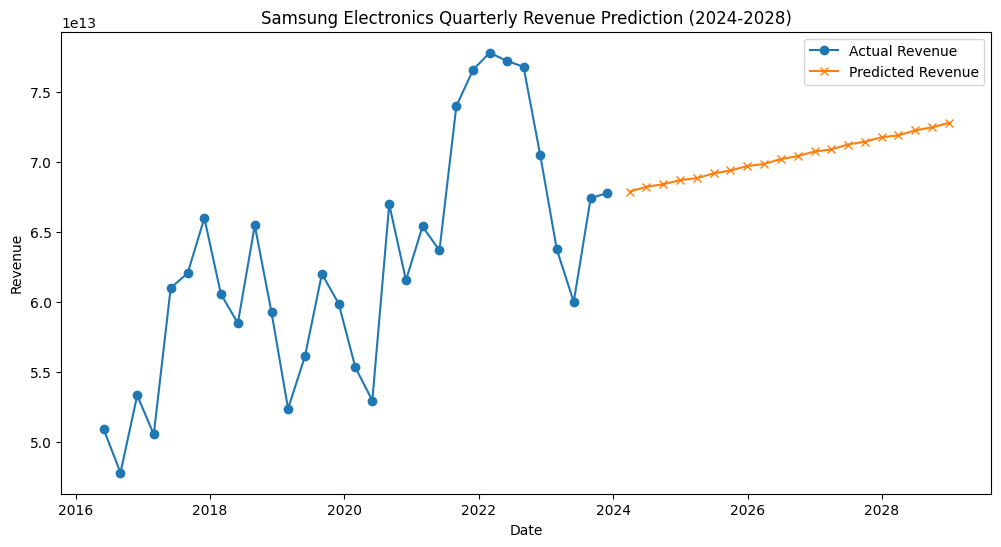

           ds          yhat
0  2024-03-31  6.787926e+13
1  2024-06-30  6.821866e+13
2  2024-09-30  6.839797e+13
3  2024-12-31  6.869522e+13
4  2025-03-31  6.882961e+13
5  2025-06-30  6.917375e+13
6  2025-09-30  6.937868e+13
7  2025-12-31  6.969784e+13
8  2026-03-31  6.984138e+13
9  2026-06-30  7.019059e+13
10 2026-09-30  7.040528e+13
11 2026-12-31  7.073634e+13
12 2027-03-31  7.087810e+13
13 2027-06-30  7.123249e+13
14 2027-09-30  7.143209e+13
15 2027-12-31  7.174926e+13
16 2028-03-31  7.188497e+13
17 2028-06-30  7.224440e+13
18 2028-09-30  7.245344e+13
19 2028-12-31  7.278458e+13


TypeError: unsupported operand type(s) for -: 'str' and 'int'

<Figure size 1200x600 with 0 Axes>